# MNIST数据集使用LeNet进行图像分类
本示例教程演示如何在MNIST数据集上用LeNet进行图像分类。
手写数字的MNIST数据集，包含60,000个用于训练的示例和10,000个用于测试的示例。这些数字已经过尺寸标准化并位于图像中心，图像是固定大小(28x28像素)，其值为0到1。该数据集的官方地址为：http://yann.lecun.com/exdb/mnist/

## 1、环境
本教程基于paddle-2.0rc1编写，如果您的环境不是本版本，请先安装paddle-2.0rc1版本。

In [1]:
import paddle
print(paddle.__version__)

2.0.0-rc1


## 2、加载数据集
我们使用飞桨自带的paddle.dataset完成mnist数据集的加载。

In [2]:
from paddle.vision.transforms import Compose, Normalize

transform = Compose([Normalize(mean=[127.5],
                               std=[127.5],
                               data_format='CHW')])
# 使用transform对数据集做归一化
print('download training data and load training data')
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)
print('load finished')

download training data and load training data
load finished


取训练集中的一条数据看一下。

train_data0 label is: [5]


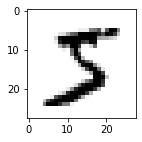

In [3]:
import numpy as np
import matplotlib.pyplot as plt
train_data0, train_label_0 = train_dataset[0][0],train_dataset[0][1]
train_data0 = train_data0.reshape([28,28])
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
print('train_data0 label is: ' + str(train_label_0))

## 3、组网
用paddle.nn下的API，如`Conv2D`、`MaxPool2D`、`Linear`完成LeNet的构建。

In [4]:
import paddle
import paddle.nn.functional as F
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # x = x.reshape((-1, 1, 28, 28))
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

## 4、方式一：基于高层API，完成模型的训练与预测
通过paddle提供的`Model` 构建实例，使用封装好的训练与测试接口，快速完成模型训练与测试。

### 4.1、使用 `Model.fit`来训练模型

In [6]:
from paddle.metric import Accuracy
model = paddle.Model(LeNet())   # 用Model封装模型
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

# 配置模型
model.prepare(
    optim,
    paddle.nn.CrossEntropyLoss(),
    Accuracy()
    )

In [8]:
# 训练模型
model.fit(train_dataset,
        epochs=2,
        batch_size=64,
        verbose=1
        )

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/2
step 938/938 [==============================] - loss: 0.0466 - acc: 0.9509 - 21ms/step          
Epoch 2/2
step 938/938 [==============================] - loss: 0.0038 - acc: 0.9828 - 21ms/step          


### 4.2、使用 `Model.evaluate` 来预测模型

In [15]:
model.evaluate(test_dataset, batch_size=64, verbose=1)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 157/157 [==============================] - loss: 7.3696e-04 - acc: 0.9493 - 7ms/step      
Eval samples: 10000


{'loss': [0.00073696], 'acc': 0.9493}

### 方式一结束
以上就是方式一，可以快速、高效的完成网络模型训练与预测。

## 5、方式二：基于基础API，完成模型的训练与预测
### 5.1、 模型训练
组网后，开始对模型进行训练，先构建`train_loader`，加载训练数据，然后定义`train`函数，设置好损失函数后，按batch加载数据，完成模型的训练。

In [10]:
import paddle.nn.functional as F
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)
# 加载训练集 batch_size 设为 64
def train(model):
    model.train()
    epochs = 2
    optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    # 用Adam作为优化函数
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = F.cross_entropy(predicts, y_data)
            # 计算损失
            acc = paddle.metric.accuracy(predicts, y_data)
            loss.backward()
            if batch_id % 300 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
            optim.step()
            optim.clear_grad()
model = LeNet()
train(model)

epoch: 0, batch_id: 0, loss is: [2.9329956], acc is: [0.09375]
epoch: 0, batch_id: 300, loss is: [0.1275514], acc is: [0.953125]
epoch: 0, batch_id: 600, loss is: [0.11902139], acc is: [0.9375]
epoch: 0, batch_id: 900, loss is: [0.05746497], acc is: [0.96875]
epoch: 1, batch_id: 0, loss is: [0.07559228], acc is: [0.96875]
epoch: 1, batch_id: 300, loss is: [0.02273748], acc is: [1.]
epoch: 1, batch_id: 600, loss is: [0.17519505], acc is: [0.953125]
epoch: 1, batch_id: 900, loss is: [0.0435793], acc is: [0.96875]


### 5.2、模型验证
训练完成后，需要验证模型的效果，此时，加载测试数据集，然后用训练好的模对测试集进行预测，计算损失与精度。

In [12]:
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载测试数据集
def test(model):
    model.eval()
    batch_size = 64
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = F.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        if batch_id % 20 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))
test(model)

batch_id: 0, loss is: [0.00826053], acc is: [1.]
batch_id: 20, loss is: [0.15725465], acc is: [0.96875]
batch_id: 40, loss is: [0.11518502], acc is: [0.96875]
batch_id: 60, loss is: [0.07907856], acc is: [0.96875]
batch_id: 80, loss is: [0.00329849], acc is: [1.]
batch_id: 100, loss is: [0.00080635], acc is: [1.]
batch_id: 120, loss is: [0.01714545], acc is: [1.]
batch_id: 140, loss is: [0.17275977], acc is: [0.953125]


### 方式二结束
以上就是方式二，通过底层API，可以清楚的看到训练和测试中的每一步过程。但是，这种方式比较复杂。因此，我们提供了训练方式一，使用高层API来完成模型的训练与预测。对比底层API，高层API能够更加快速、高效的完成模型的训练与测试。

## 6、总结


以上就是用LeNet对手写数字数据及MNIST进行分类。本示例提供了两种训练模型的方式，一种可以快速完成模型的组建与预测，非常适合新手用户上手。另一种则需要多个步骤来完成模型的训练，适合进阶用户使用。